# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

Import relevant packages

In [12]:
from datasets import load_dataset, Audio,DatasetDict, Dataset, concatenate_datasets
import numpy as np
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt
from model.AST_FineTunedModel import AST
import torchaudio
import pandas as pd
from tqdm import tqdm
import optuna
import os

Audio Augmentation on the dataset:
By using TorchAudio AudioEffector and FFmpeg effects, creating random new data.

In [13]:
# Auxiliry function that applies an effects(Audio augmentation) on a waveform
def apply_effect(waveform, sample_rate, effect, base_path, key_effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    new_wf = effector.apply(waveform, sample_rate)
    if waveform.shape[0] < new_wf.shape[0]:
      start_idx = np.random.randint(0, new_wf.shape[0] - waveform.shape[0])
      end_idx = start_idx + waveform.shape[0]
      new_wf = new_wf[start_idx:end_idx, :]
      assert new_wf.shape[0] == waveform.shape[0]
    new_path = base_path.replace(".wav",f".{key_effect}.wav")
    torchaudio.save(new_path, new_wf, sample_rate, channels_first=False)
    return new_path

#Display the spectrogram of a waveform
def show(result,sr, *, stereo=False):
    figsize = (6.4, 2.1 if stereo else 1.2)
    num_channels = result.size(1)
    f, ax = plt.subplots(num_channels, 1, squeeze=False, figsize=figsize, sharex=True)
    for i in range(num_channels):
        ax[i][0].specgram(result[:, i], Fs=sr)
    f.set_tight_layout(True)
    return result

#Add augmented samples to given datasets
def Audio_Augmentation(dataset):
  features = dataset.features
  new_data = {"file":[],"audio":[],"genre":[]}
  for i in tqdm(range(len(dataset))):
    file = dataset[i]
    # Upload the original audio waveform
    waveform , sr = torchaudio.load(file['file'], channels_first=False)
    # Create a random fast paced sample from the original audio
    fast_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=16,high=20)/10}",file["file"],"fast")
    # Create a random slow paced sample from the original audio
    slow_path = apply_effect(waveform,sr,f"atempo={np.random.randint(low=6,high=9)/10}",file["file"],"slow")
    # Create a random high pass filtered sample from the original audio
    highpass_path = apply_effect(waveform,sr,f"highpass=frequency={np.random.randint(low=1400,high=1600)}", file["file"], "highpass")
    # Create a random low pass filtered sample from the original audio
    lowpass_path = apply_effect(waveform,sr,f"lowpass=frequency={np.random.randint(low=900,high=1100)}", file["file"], "lowpass")
    # Create a sample from the original audio which contains echos of itself simulating a random sound barrier that reflects the sound 
    random_in_gain = np.random.randint(low=60,high=99)/100
    random_out_gain = np.random.randint(low=60,high=99)/100
    random_delay = np.random.randint(low=50,high=500)
    random_decay = np.random.randint(low=2,high=5)/10
    echo_path = apply_effect(waveform,sr,f"aecho=in_gain={random_in_gain}:out_gain={random_out_gain}:delays={random_delay}:decays={random_decay}", file["file"], "echo")
    # Create a mix of random augmentations sample from the original audio
    mix_effect = ",".join(
    [
        f"lowpass=frequency={np.random.randint(low=500,high=800)}:poles=1",  # apply single-pole lowpass filter
        f"atempo={np.random.randint(low=6,high=10)/10}",  # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)
    mix_path = apply_effect(waveform,sr,mix_effect, file["file"],"mix")
    # Adding the newly created samples to the original dataset
    new_paths = [fast_path, slow_path, highpass_path, lowpass_path, echo_path, mix_path]
    new_data["file"] += new_paths
    new_data["audio"] += [{"path":n_path}for n_path in new_paths]
    new_data["genre"] += [file["genre"]]*len(new_paths)
    new_data_df = pd.DataFrame(new_data)
  new_data_df = pd.DataFrame(new_data)
  new_data_dataset = Dataset.from_pandas(new_data_df).cast(features)
  new_dataset = concatenate_datasets([dataset, new_data_dataset])
  new_dataset.save_to_disk("updated_gtzan")
  return new_dataset

Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.  
Then apply the augmentation scheme defined above.

In [14]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
aug_train_set = Audio_Augmentation(train_rest["train"]).shuffle()
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
gtzan=DatasetDict({'train': train_rest["train"],'val': val_test["train"],'test': val_test["test"]})

 97%|█████████▋| 774/799 [04:52<00:07,  3.18it/s]

Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [ ]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [ ]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the datasets. 

In [ ]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Obtain the label mappings from the dataset.

In [ ]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [ ]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [ ]:
#Clean cuda cache
gc.collect()
torch.cuda.empty_cache()
#Define default hyperparameters
useOptuna=False
    #Model hyperparameters
    #No verification actions are performed on the following model hyperparametes.
model_config=AutoConfig.from_pretrained(model_id)
num_labels = len(id2label)
model_config.num_labels = num_labels
model_config.id2label=id2label
model_config.label2id=label2id
model_config.to_low_rank_layer_idx=[11] #0(first layer)-11(last layer)
model_config.low_rank_layer_rank=[2] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] rank. list the same len as to_low_rank_layer.
model_config.low_rank_layer_alpha=[8] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] alpha. list the same len as to_low_rank_layer.
model_config.dropout_rat=[0.05,0.1] # drop ratio of the two dropout layers in the classifier.
model_config.classifier_hidden_layer_size=100
    #Training method hyperparameters
batch_size = 8
gradient_accumulation_steps = 8
num_train_epochs = 1
learning_rate=5e-5
warmup_ratio=0.1
#Instantiate a default model and a default trainer
model=AST(model_config)
training_args = TrainingArguments(
    f"{model_id.split("/")[-1]}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=warmup_ratio,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=5,
    report_to='tensorboard',
)
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

if useOptuna:
# Hyperparameters search with Optuna backend over Trainer API
    # Define searched hyperparameters 
    def optuna_hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64, 128]),
            "gradient_accumulation_steps" : trial.suggest_categorical("gradient_accumulation_steps", [1,2,4,8]),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.3),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 45, 100),
        }
    # Define trails Optuna objective as evaluation set accuracy
    def compute_objective(metrics):
        return metrics["eval_accuracy"]
    # Define SQLite database to enable failed runs restoration
    storage = optuna.storages.RDBStorage(
        url="sqlite:///optuna_study.db",  # Save the study to an SQLite database file
        heartbeat_interval=60,  # Optional: To track trial status
        grace_period=120,       # Optional: Grace period for stale trials
    )
    # Hyperparameters search
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=20,
        compute_objective=compute_objective,
        storage=storage,  # Use the SQLite storage
        load_if_exists=True,  # Load the study if it already exists
        study_name="music_classification_on_AST_study",  # Name of the study
    )
    print(f"Best trial hyperparameters: {best_trial.hyperparameters}")
    print(f"Best evaluation accuracy: {best_trial.objective}")
    trainer.apply_hyperparameters(best_trial.hyperparameters, final_model=True)
#Train, save and evaluate the chosen model using the chosen trainer
trainer.train()
trainer.save_model('Best_Model')
metrics = trainer.evaluate()
print(metrics)

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/840 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\transformers\models\audio_spectrogram_transformer\modeling_audio_spectrogram_transformer.py:187: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
  1%|          | 5/840 [00:11<30:16,  2.18s/it]

{'loss': 2.3013, 'grad_norm': 3.8177661895751953, 'learning_rate': 2.9761904761904763e-06, 'epoch': 0.4}


  1%|          | 10/840 [00:21<29:37,  2.14s/it]

{'loss': 2.2948, 'grad_norm': 3.1862449645996094, 'learning_rate': 5.9523809523809525e-06, 'epoch': 0.8}


                                                
  1%|▏         | 12/840 [00:30<29:32,  2.14s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.2679200172424316, 'eval_accuracy': 0.16, 'eval_runtime': 3.4041, 'eval_samples_per_second': 29.376, 'eval_steps_per_second': 3.819, 'epoch': 0.96}


  2%|▏         | 15/840 [00:36<37:24,  2.72s/it]

{'loss': 2.2753, 'grad_norm': 3.164750814437866, 'learning_rate': 8.92857142857143e-06, 'epoch': 1.2}


  2%|▏         | 20/840 [00:47<30:37,  2.24s/it]

{'loss': 2.2544, 'grad_norm': 3.1411828994750977, 'learning_rate': 1.1904761904761905e-05, 'epoch': 1.6}


  3%|▎         | 25/840 [00:58<29:18,  2.16s/it]

{'loss': 2.2667, 'grad_norm': 3.203516721725464, 'learning_rate': 1.4880952380952381e-05, 'epoch': 2.0}


                                                
  3%|▎         | 25/840 [01:01<29:18,  2.16s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.237656354904175, 'eval_accuracy': 0.18, 'eval_runtime': 3.4098, 'eval_samples_per_second': 29.327, 'eval_steps_per_second': 3.813, 'epoch': 2.0}


  4%|▎         | 30/840 [01:12<33:04,  2.45s/it]

{'loss': 2.2243, 'grad_norm': 3.2692689895629883, 'learning_rate': 1.785714285714286e-05, 'epoch': 2.4}


  4%|▍         | 35/840 [01:23<29:39,  2.21s/it]

{'loss': 2.2247, 'grad_norm': 3.764408588409424, 'learning_rate': 2.0833333333333336e-05, 'epoch': 2.8}


                                                
  4%|▍         | 37/840 [01:32<29:22,  2.19s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.1910643577575684, 'eval_accuracy': 0.28, 'eval_runtime': 3.4387, 'eval_samples_per_second': 29.081, 'eval_steps_per_second': 3.781, 'epoch': 2.96}


  5%|▍         | 40/840 [01:38<36:33,  2.74s/it]

{'loss': 2.1966, 'grad_norm': 3.4321722984313965, 'learning_rate': 2.380952380952381e-05, 'epoch': 3.2}


  5%|▌         | 45/840 [01:49<30:10,  2.28s/it]

{'loss': 2.1692, 'grad_norm': 3.27089524269104, 'learning_rate': 2.6785714285714288e-05, 'epoch': 3.6}


  6%|▌         | 50/840 [02:00<28:36,  2.17s/it]

{'loss': 2.1212, 'grad_norm': 3.3251335620880127, 'learning_rate': 2.9761904761904762e-05, 'epoch': 4.0}


                                                
  6%|▌         | 50/840 [02:03<28:36,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.1224024295806885, 'eval_accuracy': 0.41, 'eval_runtime': 3.4626, 'eval_samples_per_second': 28.88, 'eval_steps_per_second': 3.754, 'epoch': 4.0}


  7%|▋         | 55/840 [02:15<32:28,  2.48s/it]

{'loss': 2.0896, 'grad_norm': 2.671154499053955, 'learning_rate': 3.273809523809524e-05, 'epoch': 4.4}


  7%|▋         | 60/840 [02:26<29:25,  2.26s/it]

{'loss': 2.0439, 'grad_norm': 3.221956968307495, 'learning_rate': 3.571428571428572e-05, 'epoch': 4.8}


                                                
  7%|▋         | 62/840 [02:35<29:01,  2.24s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.032402276992798, 'eval_accuracy': 0.48, 'eval_runtime': 3.4418, 'eval_samples_per_second': 29.054, 'eval_steps_per_second': 3.777, 'epoch': 4.96}


  8%|▊         | 65/840 [02:41<35:45,  2.77s/it]

{'loss': 2.0008, 'grad_norm': 3.3737103939056396, 'learning_rate': 3.8690476190476195e-05, 'epoch': 5.2}


  8%|▊         | 70/840 [02:52<29:26,  2.29s/it]

{'loss': 1.96, 'grad_norm': 2.675820827484131, 'learning_rate': 4.166666666666667e-05, 'epoch': 5.6}


  9%|▉         | 75/840 [03:03<28:14,  2.22s/it]

{'loss': 1.9125, 'grad_norm': 3.4552600383758545, 'learning_rate': 4.464285714285715e-05, 'epoch': 6.0}


                                                
  9%|▉         | 75/840 [03:06<28:14,  2.22s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.9120702743530273, 'eval_accuracy': 0.55, 'eval_runtime': 3.5164, 'eval_samples_per_second': 28.438, 'eval_steps_per_second': 3.697, 'epoch': 6.0}


 10%|▉         | 80/840 [03:18<31:52,  2.52s/it]

{'loss': 1.8342, 'grad_norm': 3.511833667755127, 'learning_rate': 4.761904761904762e-05, 'epoch': 6.4}


 10%|█         | 85/840 [03:29<28:49,  2.29s/it]

{'loss': 1.7893, 'grad_norm': 3.1727993488311768, 'learning_rate': 4.993386243386244e-05, 'epoch': 6.8}


                                                
 10%|█         | 87/840 [03:38<28:23,  2.26s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.7713085412979126, 'eval_accuracy': 0.61, 'eval_runtime': 3.471, 'eval_samples_per_second': 28.81, 'eval_steps_per_second': 3.745, 'epoch': 6.96}


 11%|█         | 90/840 [03:44<35:20,  2.83s/it]

{'loss': 1.6987, 'grad_norm': 3.3518598079681396, 'learning_rate': 4.960317460317461e-05, 'epoch': 7.2}


 11%|█▏        | 95/840 [03:56<28:59,  2.33s/it]

{'loss': 1.651, 'grad_norm': 3.028226375579834, 'learning_rate': 4.927248677248678e-05, 'epoch': 7.6}


 12%|█▏        | 100/840 [04:07<27:30,  2.23s/it]

{'loss': 1.583, 'grad_norm': 3.0509791374206543, 'learning_rate': 4.894179894179895e-05, 'epoch': 8.0}


                                                 
 12%|█▏        | 100/840 [04:10<27:30,  2.23s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.6104345321655273, 'eval_accuracy': 0.63, 'eval_runtime': 3.4929, 'eval_samples_per_second': 28.629, 'eval_steps_per_second': 3.722, 'epoch': 8.0}


 12%|█▎        | 105/840 [04:22<30:47,  2.51s/it]

{'loss': 1.5308, 'grad_norm': 3.0158350467681885, 'learning_rate': 4.8611111111111115e-05, 'epoch': 8.4}


 13%|█▎        | 110/840 [04:33<27:37,  2.27s/it]

{'loss': 1.436, 'grad_norm': 3.1905601024627686, 'learning_rate': 4.8280423280423284e-05, 'epoch': 8.8}


                                                 
 13%|█▎        | 112/840 [04:42<27:21,  2.26s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.4646387100219727, 'eval_accuracy': 0.69, 'eval_runtime': 3.5759, 'eval_samples_per_second': 27.965, 'eval_steps_per_second': 3.635, 'epoch': 8.96}


 14%|█▎        | 115/840 [04:48<34:16,  2.84s/it]

{'loss': 1.3932, 'grad_norm': 3.1889989376068115, 'learning_rate': 4.794973544973545e-05, 'epoch': 9.2}


 14%|█▍        | 120/840 [05:00<28:27,  2.37s/it]

{'loss': 1.3384, 'grad_norm': 3.267960786819458, 'learning_rate': 4.761904761904762e-05, 'epoch': 9.6}


 15%|█▍        | 125/840 [05:11<26:49,  2.25s/it]

{'loss': 1.2915, 'grad_norm': 3.0249247550964355, 'learning_rate': 4.7288359788359796e-05, 'epoch': 10.0}


                                                 
 15%|█▍        | 125/840 [05:14<26:49,  2.25s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.3345947265625, 'eval_accuracy': 0.69, 'eval_runtime': 3.5162, 'eval_samples_per_second': 28.44, 'eval_steps_per_second': 3.697, 'epoch': 10.0}


 15%|█▌        | 130/840 [05:26<30:14,  2.56s/it]

{'loss': 1.2556, 'grad_norm': 3.5476584434509277, 'learning_rate': 4.6957671957671964e-05, 'epoch': 10.4}


 16%|█▌        | 135/840 [05:38<27:23,  2.33s/it]

{'loss': 1.1659, 'grad_norm': 3.001039743423462, 'learning_rate': 4.662698412698413e-05, 'epoch': 10.8}


                                                 
 16%|█▋        | 137/840 [05:47<26:52,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.2330200672149658, 'eval_accuracy': 0.71, 'eval_runtime': 3.5438, 'eval_samples_per_second': 28.218, 'eval_steps_per_second': 3.668, 'epoch': 10.96}


 17%|█▋        | 140/840 [05:53<33:03,  2.83s/it]

{'loss': 1.1444, 'grad_norm': 2.748638391494751, 'learning_rate': 4.62962962962963e-05, 'epoch': 11.2}


 17%|█▋        | 145/840 [06:04<27:38,  2.39s/it]

{'loss': 1.1966, 'grad_norm': 3.035932779312134, 'learning_rate': 4.596560846560847e-05, 'epoch': 11.6}


 18%|█▊        | 150/840 [06:15<26:07,  2.27s/it]

{'loss': 0.9759, 'grad_norm': 2.8868041038513184, 'learning_rate': 4.563492063492064e-05, 'epoch': 12.0}


                                                 
 18%|█▊        | 150/840 [06:19<26:07,  2.27s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.129543423652649, 'eval_accuracy': 0.73, 'eval_runtime': 3.6504, 'eval_samples_per_second': 27.395, 'eval_steps_per_second': 3.561, 'epoch': 12.0}


 18%|█▊        | 155/840 [06:31<29:44,  2.61s/it]

{'loss': 1.0218, 'grad_norm': 2.844738245010376, 'learning_rate': 4.5304232804232806e-05, 'epoch': 12.4}


 19%|█▉        | 160/840 [06:43<26:55,  2.38s/it]

{'loss': 1.0622, 'grad_norm': 3.0794131755828857, 'learning_rate': 4.4973544973544974e-05, 'epoch': 12.8}


                                                 
 19%|█▉        | 162/840 [06:52<26:47,  2.37s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 1.0541870594024658, 'eval_accuracy': 0.73, 'eval_runtime': 3.6525, 'eval_samples_per_second': 27.379, 'eval_steps_per_second': 3.559, 'epoch': 12.96}


 20%|█▉        | 165/840 [06:59<33:43,  3.00s/it]

{'loss': 0.9485, 'grad_norm': 3.674254894256592, 'learning_rate': 4.464285714285715e-05, 'epoch': 13.2}


 20%|██        | 170/840 [07:11<27:45,  2.49s/it]

{'loss': 0.8941, 'grad_norm': 3.207812547683716, 'learning_rate': 4.431216931216932e-05, 'epoch': 13.6}


 21%|██        | 175/840 [07:23<25:53,  2.34s/it]

{'loss': 0.9445, 'grad_norm': 2.6773061752319336, 'learning_rate': 4.3981481481481486e-05, 'epoch': 14.0}


                                                 
 21%|██        | 175/840 [07:26<25:53,  2.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9771350026130676, 'eval_accuracy': 0.79, 'eval_runtime': 3.6295, 'eval_samples_per_second': 27.552, 'eval_steps_per_second': 3.582, 'epoch': 14.0}


 21%|██▏       | 180/840 [07:38<28:39,  2.61s/it]

{'loss': 0.8741, 'grad_norm': 2.6101415157318115, 'learning_rate': 4.3650793650793655e-05, 'epoch': 14.4}


 22%|██▏       | 185/840 [07:50<25:34,  2.34s/it]

{'loss': 0.8907, 'grad_norm': 2.5170843601226807, 'learning_rate': 4.332010582010582e-05, 'epoch': 14.8}


                                                 
 22%|██▏       | 187/840 [07:59<25:10,  2.31s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.9217798113822937, 'eval_accuracy': 0.8, 'eval_runtime': 3.5605, 'eval_samples_per_second': 28.086, 'eval_steps_per_second': 3.651, 'epoch': 14.96}


 23%|██▎       | 190/840 [08:05<31:05,  2.87s/it]

{'loss': 0.87, 'grad_norm': 2.4399595260620117, 'learning_rate': 4.298941798941799e-05, 'epoch': 15.2}


 23%|██▎       | 195/840 [08:17<25:56,  2.41s/it]

{'loss': 0.8081, 'grad_norm': 3.4455039501190186, 'learning_rate': 4.265873015873016e-05, 'epoch': 15.6}


 24%|██▍       | 200/840 [08:28<24:16,  2.28s/it]

{'loss': 0.8313, 'grad_norm': 3.6675870418548584, 'learning_rate': 4.232804232804233e-05, 'epoch': 16.0}


                                                 
 24%|██▍       | 200/840 [08:32<24:16,  2.28s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8784143328666687, 'eval_accuracy': 0.79, 'eval_runtime': 3.6079, 'eval_samples_per_second': 27.717, 'eval_steps_per_second': 3.603, 'epoch': 16.0}


 24%|██▍       | 205/840 [08:43<27:26,  2.59s/it]

{'loss': 0.7714, 'grad_norm': 2.9647204875946045, 'learning_rate': 4.1997354497354504e-05, 'epoch': 16.4}


 25%|██▌       | 210/840 [08:55<24:42,  2.35s/it]

{'loss': 0.7386, 'grad_norm': 2.520232915878296, 'learning_rate': 4.166666666666667e-05, 'epoch': 16.8}


                                                 
 25%|██▌       | 212/840 [09:04<24:30,  2.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.8409777879714966, 'eval_accuracy': 0.81, 'eval_runtime': 3.5963, 'eval_samples_per_second': 27.807, 'eval_steps_per_second': 3.615, 'epoch': 16.96}


 26%|██▌       | 215/840 [09:10<30:00,  2.88s/it]

{'loss': 0.8556, 'grad_norm': 3.1476361751556396, 'learning_rate': 4.133597883597884e-05, 'epoch': 17.2}


 26%|██▌       | 220/840 [09:22<24:44,  2.40s/it]

{'loss': 0.7126, 'grad_norm': 4.017848968505859, 'learning_rate': 4.100529100529101e-05, 'epoch': 17.6}


 27%|██▋       | 225/840 [09:33<23:26,  2.29s/it]

{'loss': 0.737, 'grad_norm': 2.533562183380127, 'learning_rate': 4.067460317460318e-05, 'epoch': 18.0}


                                                 
 27%|██▋       | 225/840 [09:37<23:26,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7987817525863647, 'eval_accuracy': 0.83, 'eval_runtime': 3.5823, 'eval_samples_per_second': 27.915, 'eval_steps_per_second': 3.629, 'epoch': 18.0}


 27%|██▋       | 230/840 [09:49<26:39,  2.62s/it]

{'loss': 0.758, 'grad_norm': 2.894252061843872, 'learning_rate': 4.0343915343915346e-05, 'epoch': 18.4}


 28%|██▊       | 235/840 [10:00<23:41,  2.35s/it]

{'loss': 0.6925, 'grad_norm': 2.772920608520508, 'learning_rate': 4.0013227513227514e-05, 'epoch': 18.8}


                                                 
 28%|██▊       | 237/840 [10:10<23:33,  2.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7699987888336182, 'eval_accuracy': 0.84, 'eval_runtime': 3.6728, 'eval_samples_per_second': 27.227, 'eval_steps_per_second': 3.54, 'epoch': 18.96}


 29%|██▊       | 240/840 [10:16<29:18,  2.93s/it]

{'loss': 0.7144, 'grad_norm': 3.5666491985321045, 'learning_rate': 3.968253968253968e-05, 'epoch': 19.2}


 29%|██▉       | 245/840 [10:28<23:58,  2.42s/it]

{'loss': 0.6164, 'grad_norm': 2.729060649871826, 'learning_rate': 3.935185185185186e-05, 'epoch': 19.6}


 30%|██▉       | 250/840 [10:39<22:33,  2.29s/it]

{'loss': 0.717, 'grad_norm': 3.0897881984710693, 'learning_rate': 3.9021164021164026e-05, 'epoch': 20.0}


                                                 
 30%|██▉       | 250/840 [10:43<22:33,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.750154435634613, 'eval_accuracy': 0.82, 'eval_runtime': 3.772, 'eval_samples_per_second': 26.511, 'eval_steps_per_second': 3.446, 'epoch': 20.0}


 30%|███       | 255/840 [10:56<26:17,  2.70s/it]

{'loss': 0.6294, 'grad_norm': 3.0005300045013428, 'learning_rate': 3.8690476190476195e-05, 'epoch': 20.4}


 31%|███       | 260/840 [11:08<23:44,  2.46s/it]

{'loss': 0.6687, 'grad_norm': 2.714909076690674, 'learning_rate': 3.835978835978836e-05, 'epoch': 20.8}


                                                 
 31%|███       | 262/840 [11:17<23:19,  2.42s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.721893310546875, 'eval_accuracy': 0.82, 'eval_runtime': 3.5491, 'eval_samples_per_second': 28.177, 'eval_steps_per_second': 3.663, 'epoch': 20.96}


 32%|███▏      | 265/840 [11:23<27:59,  2.92s/it]

{'loss': 0.6803, 'grad_norm': 3.0088815689086914, 'learning_rate': 3.802910052910053e-05, 'epoch': 21.2}


 32%|███▏      | 270/840 [11:35<23:02,  2.43s/it]

{'loss': 0.6358, 'grad_norm': 2.244304895401001, 'learning_rate': 3.76984126984127e-05, 'epoch': 21.6}


 33%|███▎      | 275/840 [11:46<21:37,  2.30s/it]

{'loss': 0.6154, 'grad_norm': 3.3505849838256836, 'learning_rate': 3.736772486772487e-05, 'epoch': 22.0}


                                                 
 33%|███▎      | 275/840 [11:50<21:37,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.7045355439186096, 'eval_accuracy': 0.82, 'eval_runtime': 3.5773, 'eval_samples_per_second': 27.954, 'eval_steps_per_second': 3.634, 'epoch': 22.0}


 33%|███▎      | 280/840 [12:02<24:10,  2.59s/it]

{'loss': 0.5983, 'grad_norm': 2.5322952270507812, 'learning_rate': 3.7037037037037037e-05, 'epoch': 22.4}


 34%|███▍      | 285/840 [12:13<21:45,  2.35s/it]

{'loss': 0.6237, 'grad_norm': 2.9348530769348145, 'learning_rate': 3.6706349206349205e-05, 'epoch': 22.8}


                                                 
 34%|███▍      | 287/840 [12:23<21:35,  2.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6856341361999512, 'eval_accuracy': 0.82, 'eval_runtime': 3.6116, 'eval_samples_per_second': 27.689, 'eval_steps_per_second': 3.6, 'epoch': 22.96}


 35%|███▍      | 290/840 [12:29<26:35,  2.90s/it]

{'loss': 0.629, 'grad_norm': 2.2600340843200684, 'learning_rate': 3.637566137566138e-05, 'epoch': 23.2}


 35%|███▌      | 295/840 [12:41<22:03,  2.43s/it]

{'loss': 0.6232, 'grad_norm': 4.155210971832275, 'learning_rate': 3.604497354497355e-05, 'epoch': 23.6}


 36%|███▌      | 300/840 [12:52<20:41,  2.30s/it]

{'loss': 0.584, 'grad_norm': 2.4683687686920166, 'learning_rate': 3.571428571428572e-05, 'epoch': 24.0}


                                                 
 36%|███▌      | 300/840 [12:56<20:41,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6622827053070068, 'eval_accuracy': 0.82, 'eval_runtime': 3.6031, 'eval_samples_per_second': 27.754, 'eval_steps_per_second': 3.608, 'epoch': 24.0}


 36%|███▋      | 305/840 [13:08<22:59,  2.58s/it]

{'loss': 0.6508, 'grad_norm': 2.5618808269500732, 'learning_rate': 3.5383597883597885e-05, 'epoch': 24.4}


 37%|███▋      | 310/840 [13:19<20:40,  2.34s/it]

{'loss': 0.5513, 'grad_norm': 1.8727426528930664, 'learning_rate': 3.5052910052910054e-05, 'epoch': 24.8}


                                                 
 37%|███▋      | 312/840 [13:28<20:25,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6489318609237671, 'eval_accuracy': 0.82, 'eval_runtime': 3.5624, 'eval_samples_per_second': 28.071, 'eval_steps_per_second': 3.649, 'epoch': 24.96}


 38%|███▊      | 315/840 [13:34<25:11,  2.88s/it]

{'loss': 0.5378, 'grad_norm': 2.9658730030059814, 'learning_rate': 3.472222222222222e-05, 'epoch': 25.2}


 38%|███▊      | 320/840 [13:46<21:00,  2.42s/it]

{'loss': 0.5976, 'grad_norm': 3.243434190750122, 'learning_rate': 3.439153439153439e-05, 'epoch': 25.6}


 39%|███▊      | 325/840 [13:58<19:40,  2.29s/it]

{'loss': 0.5374, 'grad_norm': 2.482527017593384, 'learning_rate': 3.406084656084656e-05, 'epoch': 26.0}


                                                 
 39%|███▊      | 325/840 [14:01<19:40,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6353827118873596, 'eval_accuracy': 0.82, 'eval_runtime': 3.6028, 'eval_samples_per_second': 27.756, 'eval_steps_per_second': 3.608, 'epoch': 26.0}


 39%|███▉      | 330/840 [14:13<22:07,  2.60s/it]

{'loss': 0.5749, 'grad_norm': 2.4066107273101807, 'learning_rate': 3.3730158730158734e-05, 'epoch': 26.4}


 40%|███▉      | 335/840 [14:25<19:44,  2.35s/it]

{'loss': 0.5336, 'grad_norm': 3.1856496334075928, 'learning_rate': 3.33994708994709e-05, 'epoch': 26.8}


                                                 
 40%|████      | 337/840 [14:34<19:27,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6294348239898682, 'eval_accuracy': 0.82, 'eval_runtime': 3.555, 'eval_samples_per_second': 28.13, 'eval_steps_per_second': 3.657, 'epoch': 26.96}


 40%|████      | 340/840 [14:40<24:15,  2.91s/it]

{'loss': 0.5786, 'grad_norm': 2.4580800533294678, 'learning_rate': 3.306878306878307e-05, 'epoch': 27.2}


 41%|████      | 345/840 [14:52<19:43,  2.39s/it]

{'loss': 0.5148, 'grad_norm': 3.3279170989990234, 'learning_rate': 3.273809523809524e-05, 'epoch': 27.6}


 42%|████▏     | 350/840 [15:03<18:35,  2.28s/it]

{'loss': 0.5528, 'grad_norm': 3.1991515159606934, 'learning_rate': 3.240740740740741e-05, 'epoch': 28.0}


                                                 
 42%|████▏     | 350/840 [15:07<18:35,  2.28s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6139624118804932, 'eval_accuracy': 0.82, 'eval_runtime': 3.6974, 'eval_samples_per_second': 27.046, 'eval_steps_per_second': 3.516, 'epoch': 28.0}


 42%|████▏     | 355/840 [15:19<20:52,  2.58s/it]

{'loss': 0.5319, 'grad_norm': 1.4295567274093628, 'learning_rate': 3.2076719576719576e-05, 'epoch': 28.4}


 43%|████▎     | 360/840 [15:30<19:14,  2.41s/it]

{'loss': 0.5075, 'grad_norm': 2.7200021743774414, 'learning_rate': 3.1746031746031745e-05, 'epoch': 28.8}


                                                 
 43%|████▎     | 362/840 [15:40<18:46,  2.36s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.6069409251213074, 'eval_accuracy': 0.81, 'eval_runtime': 3.645, 'eval_samples_per_second': 27.435, 'eval_steps_per_second': 3.567, 'epoch': 28.96}


 43%|████▎     | 365/840 [15:46<23:22,  2.95s/it]

{'loss': 0.5407, 'grad_norm': 2.645366668701172, 'learning_rate': 3.141534391534391e-05, 'epoch': 29.2}


 44%|████▍     | 370/840 [15:58<18:52,  2.41s/it]

{'loss': 0.4967, 'grad_norm': 2.4126217365264893, 'learning_rate': 3.108465608465609e-05, 'epoch': 29.6}


 45%|████▍     | 375/840 [16:09<17:53,  2.31s/it]

{'loss': 0.5387, 'grad_norm': 4.308627605438232, 'learning_rate': 3.075396825396826e-05, 'epoch': 30.0}


                                                 
 45%|████▍     | 375/840 [16:13<17:53,  2.31s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.597757875919342, 'eval_accuracy': 0.82, 'eval_runtime': 3.6631, 'eval_samples_per_second': 27.299, 'eval_steps_per_second': 3.549, 'epoch': 30.0}


 45%|████▌     | 380/840 [16:25<19:53,  2.59s/it]

{'loss': 0.5498, 'grad_norm': 2.900761604309082, 'learning_rate': 3.0423280423280425e-05, 'epoch': 30.4}


 46%|████▌     | 385/840 [16:37<17:53,  2.36s/it]

{'loss': 0.5057, 'grad_norm': 3.6243460178375244, 'learning_rate': 3.0092592592592593e-05, 'epoch': 30.8}


                                                 
 46%|████▌     | 387/840 [16:46<17:45,  2.35s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5867312550544739, 'eval_accuracy': 0.82, 'eval_runtime': 3.7314, 'eval_samples_per_second': 26.799, 'eval_steps_per_second': 3.484, 'epoch': 30.96}


 46%|████▋     | 390/840 [16:53<22:30,  3.00s/it]

{'loss': 0.4722, 'grad_norm': 4.200016498565674, 'learning_rate': 2.9761904761904762e-05, 'epoch': 31.2}


 47%|████▋     | 395/840 [17:05<18:38,  2.51s/it]

{'loss': 0.4727, 'grad_norm': 2.2702510356903076, 'learning_rate': 2.943121693121693e-05, 'epoch': 31.6}


 48%|████▊     | 400/840 [17:17<17:21,  2.37s/it]

{'loss': 0.5228, 'grad_norm': 2.634554386138916, 'learning_rate': 2.91005291005291e-05, 'epoch': 32.0}


                                                 
 48%|████▊     | 400/840 [17:20<17:21,  2.37s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.577162504196167, 'eval_accuracy': 0.83, 'eval_runtime': 3.6443, 'eval_samples_per_second': 27.44, 'eval_steps_per_second': 3.567, 'epoch': 32.0}


 48%|████▊     | 405/840 [17:32<18:52,  2.60s/it]

{'loss': 0.486, 'grad_norm': 3.280815362930298, 'learning_rate': 2.876984126984127e-05, 'epoch': 32.4}


 49%|████▉     | 410/840 [17:44<16:51,  2.35s/it]

{'loss': 0.4861, 'grad_norm': 2.742377281188965, 'learning_rate': 2.8439153439153442e-05, 'epoch': 32.8}


                                                 
 49%|████▉     | 412/840 [17:53<16:36,  2.33s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.573352038860321, 'eval_accuracy': 0.83, 'eval_runtime': 3.5536, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 3.658, 'epoch': 32.96}


 49%|████▉     | 415/840 [17:59<20:48,  2.94s/it]

{'loss': 0.5847, 'grad_norm': 3.1538755893707275, 'learning_rate': 2.810846560846561e-05, 'epoch': 33.2}


 50%|█████     | 420/840 [18:11<16:49,  2.40s/it]

{'loss': 0.4893, 'grad_norm': 2.3358452320098877, 'learning_rate': 2.777777777777778e-05, 'epoch': 33.6}


 51%|█████     | 425/840 [18:22<15:50,  2.29s/it]

{'loss': 0.4296, 'grad_norm': 1.9176334142684937, 'learning_rate': 2.7447089947089948e-05, 'epoch': 34.0}


                                                 
 51%|█████     | 425/840 [18:26<15:50,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.565822422504425, 'eval_accuracy': 0.83, 'eval_runtime': 3.6978, 'eval_samples_per_second': 27.043, 'eval_steps_per_second': 3.516, 'epoch': 34.0}


 51%|█████     | 430/840 [18:38<17:46,  2.60s/it]

{'loss': 0.4593, 'grad_norm': 3.5442264080047607, 'learning_rate': 2.7116402116402116e-05, 'epoch': 34.4}


 52%|█████▏    | 435/840 [18:49<15:51,  2.35s/it]

{'loss': 0.5062, 'grad_norm': 3.4417431354522705, 'learning_rate': 2.6785714285714288e-05, 'epoch': 34.8}


                                                 
 52%|█████▏    | 437/840 [18:59<15:36,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5559777617454529, 'eval_accuracy': 0.83, 'eval_runtime': 3.6934, 'eval_samples_per_second': 27.076, 'eval_steps_per_second': 3.52, 'epoch': 34.96}


 52%|█████▏    | 440/840 [19:05<19:28,  2.92s/it]

{'loss': 0.4518, 'grad_norm': 2.0832269191741943, 'learning_rate': 2.6455026455026456e-05, 'epoch': 35.2}


 53%|█████▎    | 445/840 [19:17<15:51,  2.41s/it]

{'loss': 0.4698, 'grad_norm': 2.659489154815674, 'learning_rate': 2.6124338624338625e-05, 'epoch': 35.6}


 54%|█████▎    | 450/840 [19:28<14:58,  2.30s/it]

{'loss': 0.4792, 'grad_norm': 4.911659240722656, 'learning_rate': 2.5793650793650796e-05, 'epoch': 36.0}


                                                 
 54%|█████▎    | 450/840 [19:32<14:58,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5557394623756409, 'eval_accuracy': 0.83, 'eval_runtime': 3.5877, 'eval_samples_per_second': 27.873, 'eval_steps_per_second': 3.624, 'epoch': 36.0}


 54%|█████▍    | 455/840 [19:44<16:45,  2.61s/it]

{'loss': 0.4299, 'grad_norm': 3.237400770187378, 'learning_rate': 2.5462962962962965e-05, 'epoch': 36.4}


 55%|█████▍    | 460/840 [19:55<14:51,  2.35s/it]

{'loss': 0.4226, 'grad_norm': 3.3041956424713135, 'learning_rate': 2.5132275132275137e-05, 'epoch': 36.8}


                                                 
 55%|█████▌    | 462/840 [20:05<14:39,  2.33s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5531368851661682, 'eval_accuracy': 0.83, 'eval_runtime': 3.7007, 'eval_samples_per_second': 27.022, 'eval_steps_per_second': 3.513, 'epoch': 36.96}


 55%|█████▌    | 465/840 [20:11<18:10,  2.91s/it]

{'loss': 0.5381, 'grad_norm': 2.4735267162323, 'learning_rate': 2.4801587301587305e-05, 'epoch': 37.2}


 56%|█████▌    | 470/840 [20:22<14:46,  2.40s/it]

{'loss': 0.439, 'grad_norm': 2.381422281265259, 'learning_rate': 2.4470899470899473e-05, 'epoch': 37.6}


 57%|█████▋    | 475/840 [20:34<13:55,  2.29s/it]

{'loss': 0.4695, 'grad_norm': 2.1480534076690674, 'learning_rate': 2.4140211640211642e-05, 'epoch': 38.0}


                                                 
 57%|█████▋    | 475/840 [20:38<13:55,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5477151274681091, 'eval_accuracy': 0.83, 'eval_runtime': 3.6459, 'eval_samples_per_second': 27.428, 'eval_steps_per_second': 3.566, 'epoch': 38.0}


 57%|█████▋    | 480/840 [20:49<15:35,  2.60s/it]

{'loss': 0.4799, 'grad_norm': 3.1003258228302, 'learning_rate': 2.380952380952381e-05, 'epoch': 38.4}


 58%|█████▊    | 485/840 [21:01<13:55,  2.35s/it]

{'loss': 0.4891, 'grad_norm': 4.363232612609863, 'learning_rate': 2.3478835978835982e-05, 'epoch': 38.8}


                                                 
 58%|█████▊    | 487/840 [21:10<13:37,  2.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5416192412376404, 'eval_accuracy': 0.83, 'eval_runtime': 3.6658, 'eval_samples_per_second': 27.279, 'eval_steps_per_second': 3.546, 'epoch': 38.96}


 58%|█████▊    | 490/840 [21:17<16:58,  2.91s/it]

{'loss': 0.4176, 'grad_norm': 2.6473724842071533, 'learning_rate': 2.314814814814815e-05, 'epoch': 39.2}


 59%|█████▉    | 495/840 [21:31<17:40,  3.07s/it]

{'loss': 0.4639, 'grad_norm': 3.440173625946045, 'learning_rate': 2.281746031746032e-05, 'epoch': 39.6}


 60%|█████▉    | 500/840 [21:47<18:10,  3.21s/it]

{'loss': 0.4645, 'grad_norm': 2.834733247756958, 'learning_rate': 2.2486772486772487e-05, 'epoch': 40.0}


                                                 
 60%|█████▉    | 500/840 [21:53<18:10,  3.21s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.535139799118042, 'eval_accuracy': 0.83, 'eval_runtime': 5.4332, 'eval_samples_per_second': 18.405, 'eval_steps_per_second': 2.393, 'epoch': 40.0}


 60%|██████    | 505/840 [22:10<20:50,  3.73s/it]

{'loss': 0.4463, 'grad_norm': 2.368300676345825, 'learning_rate': 2.215608465608466e-05, 'epoch': 40.4}


 61%|██████    | 510/840 [22:26<18:26,  3.35s/it]

{'loss': 0.462, 'grad_norm': 2.604339122772217, 'learning_rate': 2.1825396825396827e-05, 'epoch': 40.8}


                                                 
 61%|██████    | 512/840 [22:41<18:38,  3.41s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5352270603179932, 'eval_accuracy': 0.83, 'eval_runtime': 6.0341, 'eval_samples_per_second': 16.573, 'eval_steps_per_second': 2.154, 'epoch': 40.96}


 61%|██████▏   | 515/840 [22:50<23:20,  4.31s/it]

{'loss': 0.4374, 'grad_norm': 2.4055957794189453, 'learning_rate': 2.1494708994708996e-05, 'epoch': 41.2}


 62%|██████▏   | 520/840 [23:08<18:51,  3.53s/it]

{'loss': 0.4377, 'grad_norm': 3.5814504623413086, 'learning_rate': 2.1164021164021164e-05, 'epoch': 41.6}


 62%|██████▎   | 525/840 [23:24<17:08,  3.26s/it]

{'loss': 0.4543, 'grad_norm': 2.6644625663757324, 'learning_rate': 2.0833333333333336e-05, 'epoch': 42.0}


                                                 
 62%|██████▎   | 525/840 [23:30<17:08,  3.26s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5298808217048645, 'eval_accuracy': 0.83, 'eval_runtime': 5.9997, 'eval_samples_per_second': 16.668, 'eval_steps_per_second': 2.167, 'epoch': 42.0}


 63%|██████▎   | 530/840 [23:48<19:36,  3.80s/it]

{'loss': 0.389, 'grad_norm': 1.535791039466858, 'learning_rate': 2.0502645502645504e-05, 'epoch': 42.4}


 64%|██████▎   | 535/840 [24:04<16:47,  3.30s/it]

{'loss': 0.4656, 'grad_norm': 4.289156913757324, 'learning_rate': 2.0171957671957673e-05, 'epoch': 42.8}


                                                 
 64%|██████▍   | 537/840 [24:17<16:18,  3.23s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5301121473312378, 'eval_accuracy': 0.83, 'eval_runtime': 5.1099, 'eval_samples_per_second': 19.57, 'eval_steps_per_second': 2.544, 'epoch': 42.96}


 64%|██████▍   | 540/840 [24:27<21:13,  4.25s/it]

{'loss': 0.4606, 'grad_norm': 3.315776824951172, 'learning_rate': 1.984126984126984e-05, 'epoch': 43.2}


 65%|██████▍   | 545/840 [24:43<16:12,  3.30s/it]

{'loss': 0.461, 'grad_norm': 3.2679731845855713, 'learning_rate': 1.9510582010582013e-05, 'epoch': 43.6}


 65%|██████▌   | 550/840 [24:58<14:54,  3.09s/it]

{'loss': 0.4013, 'grad_norm': 2.974432945251465, 'learning_rate': 1.917989417989418e-05, 'epoch': 44.0}


                                                 
 65%|██████▌   | 550/840 [25:02<14:54,  3.09s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5299438238143921, 'eval_accuracy': 0.83, 'eval_runtime': 3.4759, 'eval_samples_per_second': 28.769, 'eval_steps_per_second': 3.74, 'epoch': 44.0}


 66%|██████▌   | 555/840 [25:13<12:50,  2.70s/it]

{'loss': 0.4786, 'grad_norm': 2.7149763107299805, 'learning_rate': 1.884920634920635e-05, 'epoch': 44.4}


 67%|██████▋   | 560/840 [25:30<15:32,  3.33s/it]

{'loss': 0.3924, 'grad_norm': 2.262598991394043, 'learning_rate': 1.8518518518518518e-05, 'epoch': 44.8}


                                                 
 67%|██████▋   | 562/840 [25:44<16:02,  3.46s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5269427299499512, 'eval_accuracy': 0.83, 'eval_runtime': 4.9381, 'eval_samples_per_second': 20.251, 'eval_steps_per_second': 2.633, 'epoch': 44.96}


 67%|██████▋   | 565/840 [25:53<19:05,  4.17s/it]

{'loss': 0.4298, 'grad_norm': 3.227091073989868, 'learning_rate': 1.818783068783069e-05, 'epoch': 45.2}


 68%|██████▊   | 570/840 [26:08<14:51,  3.30s/it]

{'loss': 0.4263, 'grad_norm': 2.7973341941833496, 'learning_rate': 1.785714285714286e-05, 'epoch': 45.6}


 68%|██████▊   | 575/840 [26:24<13:38,  3.09s/it]

{'loss': 0.4248, 'grad_norm': 3.2532944679260254, 'learning_rate': 1.7526455026455027e-05, 'epoch': 46.0}


                                                 
 68%|██████▊   | 575/840 [26:29<13:38,  3.09s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5240707397460938, 'eval_accuracy': 0.83, 'eval_runtime': 5.2898, 'eval_samples_per_second': 18.904, 'eval_steps_per_second': 2.458, 'epoch': 46.0}


 69%|██████▉   | 580/840 [26:42<12:27,  2.88s/it]

{'loss': 0.4328, 'grad_norm': 2.5404539108276367, 'learning_rate': 1.7195767195767195e-05, 'epoch': 46.4}


 70%|██████▉   | 585/840 [26:53<10:04,  2.37s/it]

{'loss': 0.4217, 'grad_norm': 2.9949142932891846, 'learning_rate': 1.6865079365079367e-05, 'epoch': 46.8}


                                                 
 70%|██████▉   | 587/840 [27:03<09:53,  2.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5207816958427429, 'eval_accuracy': 0.83, 'eval_runtime': 3.5733, 'eval_samples_per_second': 27.985, 'eval_steps_per_second': 3.638, 'epoch': 46.96}


 70%|███████   | 590/840 [27:09<11:58,  2.87s/it]

{'loss': 0.4452, 'grad_norm': 2.599271774291992, 'learning_rate': 1.6534391534391536e-05, 'epoch': 47.2}


 71%|███████   | 595/840 [27:20<09:42,  2.38s/it]

{'loss': 0.4897, 'grad_norm': 3.357149124145508, 'learning_rate': 1.6203703703703704e-05, 'epoch': 47.6}


 71%|███████▏  | 600/840 [27:31<09:06,  2.28s/it]

{'loss': 0.3994, 'grad_norm': 3.4929652214050293, 'learning_rate': 1.5873015873015872e-05, 'epoch': 48.0}


                                                 
 71%|███████▏  | 600/840 [27:35<09:06,  2.28s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5222516059875488, 'eval_accuracy': 0.83, 'eval_runtime': 3.5281, 'eval_samples_per_second': 28.344, 'eval_steps_per_second': 3.685, 'epoch': 48.0}


 72%|███████▏  | 605/840 [27:47<10:08,  2.59s/it]

{'loss': 0.4241, 'grad_norm': 3.680633783340454, 'learning_rate': 1.5542328042328044e-05, 'epoch': 48.4}


 73%|███████▎  | 610/840 [27:59<09:09,  2.39s/it]

{'loss': 0.4386, 'grad_norm': 2.783996343612671, 'learning_rate': 1.5211640211640213e-05, 'epoch': 48.8}


                                                 
 73%|███████▎  | 612/840 [28:08<08:56,  2.35s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5201768279075623, 'eval_accuracy': 0.83, 'eval_runtime': 3.5902, 'eval_samples_per_second': 27.853, 'eval_steps_per_second': 3.621, 'epoch': 48.96}


 73%|███████▎  | 615/840 [28:14<10:51,  2.90s/it]

{'loss': 0.4144, 'grad_norm': 2.61957049369812, 'learning_rate': 1.4880952380952381e-05, 'epoch': 49.2}


 74%|███████▍  | 620/840 [28:26<08:51,  2.41s/it]

{'loss': 0.4594, 'grad_norm': 2.7519137859344482, 'learning_rate': 1.455026455026455e-05, 'epoch': 49.6}


 74%|███████▍  | 625/840 [28:37<08:12,  2.29s/it]

{'loss': 0.3891, 'grad_norm': 3.645372152328491, 'learning_rate': 1.4219576719576721e-05, 'epoch': 50.0}


                                                 
 74%|███████▍  | 625/840 [28:41<08:12,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.515939474105835, 'eval_accuracy': 0.83, 'eval_runtime': 3.5632, 'eval_samples_per_second': 28.065, 'eval_steps_per_second': 3.648, 'epoch': 50.0}


 75%|███████▌  | 630/840 [28:53<09:39,  2.76s/it]

{'loss': 0.4436, 'grad_norm': 1.9997450113296509, 'learning_rate': 1.388888888888889e-05, 'epoch': 50.4}


 76%|███████▌  | 635/840 [29:10<11:05,  3.24s/it]

{'loss': 0.3926, 'grad_norm': 3.8100192546844482, 'learning_rate': 1.3558201058201058e-05, 'epoch': 50.8}


                                                 
 76%|███████▌  | 637/840 [29:22<11:01,  3.26s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5133169293403625, 'eval_accuracy': 0.83, 'eval_runtime': 4.9412, 'eval_samples_per_second': 20.238, 'eval_steps_per_second': 2.631, 'epoch': 50.96}


 76%|███████▌  | 640/840 [29:31<13:32,  4.06s/it]

{'loss': 0.4343, 'grad_norm': 1.8190499544143677, 'learning_rate': 1.3227513227513228e-05, 'epoch': 51.2}


 77%|███████▋  | 645/840 [29:47<10:39,  3.28s/it]

{'loss': 0.3863, 'grad_norm': 2.761277198791504, 'learning_rate': 1.2896825396825398e-05, 'epoch': 51.6}


 77%|███████▋  | 650/840 [30:03<09:43,  3.07s/it]

{'loss': 0.444, 'grad_norm': 2.248702049255371, 'learning_rate': 1.2566137566137568e-05, 'epoch': 52.0}


                                                 
 77%|███████▋  | 650/840 [30:08<09:43,  3.07s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5108345150947571, 'eval_accuracy': 0.83, 'eval_runtime': 5.0596, 'eval_samples_per_second': 19.764, 'eval_steps_per_second': 2.569, 'epoch': 52.0}


 78%|███████▊  | 655/840 [30:24<10:57,  3.55s/it]

{'loss': 0.4022, 'grad_norm': 1.5929630994796753, 'learning_rate': 1.2235449735449737e-05, 'epoch': 52.4}


 79%|███████▊  | 660/840 [30:40<09:33,  3.18s/it]

{'loss': 0.4481, 'grad_norm': 2.022409200668335, 'learning_rate': 1.1904761904761905e-05, 'epoch': 52.8}


                                                 
 79%|███████▉  | 662/840 [30:53<09:51,  3.32s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5092425346374512, 'eval_accuracy': 0.83, 'eval_runtime': 4.9465, 'eval_samples_per_second': 20.217, 'eval_steps_per_second': 2.628, 'epoch': 52.96}


 79%|███████▉  | 665/840 [31:02<12:14,  4.20s/it]

{'loss': 0.4098, 'grad_norm': 2.3835906982421875, 'learning_rate': 1.1574074074074075e-05, 'epoch': 53.2}


 80%|███████▉  | 670/840 [31:18<09:18,  3.28s/it]

{'loss': 0.3974, 'grad_norm': 3.049882411956787, 'learning_rate': 1.1243386243386244e-05, 'epoch': 53.6}


 80%|████████  | 675/840 [31:34<08:48,  3.20s/it]

{'loss': 0.4086, 'grad_norm': 2.194913387298584, 'learning_rate': 1.0912698412698414e-05, 'epoch': 54.0}


                                                 
 80%|████████  | 675/840 [31:39<08:48,  3.20s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5073354840278625, 'eval_accuracy': 0.84, 'eval_runtime': 5.4023, 'eval_samples_per_second': 18.511, 'eval_steps_per_second': 2.406, 'epoch': 54.0}


 81%|████████  | 680/840 [31:56<09:42,  3.64s/it]

{'loss': 0.4211, 'grad_norm': 2.11126708984375, 'learning_rate': 1.0582010582010582e-05, 'epoch': 54.4}


 82%|████████▏ | 685/840 [32:12<08:34,  3.32s/it]

{'loss': 0.3806, 'grad_norm': 2.253575563430786, 'learning_rate': 1.0251322751322752e-05, 'epoch': 54.8}


                                                 
 82%|████████▏ | 687/840 [32:26<08:25,  3.31s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5076555013656616, 'eval_accuracy': 0.84, 'eval_runtime': 5.3488, 'eval_samples_per_second': 18.696, 'eval_steps_per_second': 2.43, 'epoch': 54.96}


 82%|████████▏ | 690/840 [32:35<10:16,  4.11s/it]

{'loss': 0.4833, 'grad_norm': 2.9444689750671387, 'learning_rate': 9.92063492063492e-06, 'epoch': 55.2}


 83%|████████▎ | 695/840 [32:51<08:04,  3.34s/it]

{'loss': 0.3691, 'grad_norm': 3.0358030796051025, 'learning_rate': 9.58994708994709e-06, 'epoch': 55.6}


 83%|████████▎ | 700/840 [33:06<07:16,  3.12s/it]

{'loss': 0.4155, 'grad_norm': 2.785792350769043, 'learning_rate': 9.259259259259259e-06, 'epoch': 56.0}


                                                 
 83%|████████▎ | 700/840 [33:11<07:16,  3.12s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5074400305747986, 'eval_accuracy': 0.83, 'eval_runtime': 5.0152, 'eval_samples_per_second': 19.939, 'eval_steps_per_second': 2.592, 'epoch': 56.0}


 84%|████████▍ | 705/840 [33:27<07:45,  3.45s/it]

{'loss': 0.4251, 'grad_norm': 3.310476779937744, 'learning_rate': 8.92857142857143e-06, 'epoch': 56.4}


 85%|████████▍ | 710/840 [33:43<06:50,  3.16s/it]

{'loss': 0.4, 'grad_norm': 2.8841323852539062, 'learning_rate': 8.597883597883598e-06, 'epoch': 56.8}


                                                 
 85%|████████▍ | 712/840 [33:55<06:39,  3.12s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5059318542480469, 'eval_accuracy': 0.83, 'eval_runtime': 4.7732, 'eval_samples_per_second': 20.95, 'eval_steps_per_second': 2.724, 'epoch': 56.96}


 85%|████████▌ | 715/840 [34:03<08:02,  3.86s/it]

{'loss': 0.4073, 'grad_norm': 3.6661221981048584, 'learning_rate': 8.267195767195768e-06, 'epoch': 57.2}


 86%|████████▌ | 720/840 [34:19<06:24,  3.20s/it]

{'loss': 0.3934, 'grad_norm': 2.9023613929748535, 'learning_rate': 7.936507936507936e-06, 'epoch': 57.6}


 86%|████████▋ | 725/840 [34:34<05:48,  3.03s/it]

{'loss': 0.3967, 'grad_norm': 2.380499839782715, 'learning_rate': 7.605820105820106e-06, 'epoch': 58.0}


                                                 
 86%|████████▋ | 725/840 [34:39<05:48,  3.03s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5048801898956299, 'eval_accuracy': 0.83, 'eval_runtime': 5.096, 'eval_samples_per_second': 19.623, 'eval_steps_per_second': 2.551, 'epoch': 58.0}


 87%|████████▋ | 730/840 [34:51<05:15,  2.87s/it]

{'loss': 0.3872, 'grad_norm': 2.139035701751709, 'learning_rate': 7.275132275132275e-06, 'epoch': 58.4}


 88%|████████▊ | 735/840 [35:05<04:42,  2.70s/it]

{'loss': 0.438, 'grad_norm': 3.898977041244507, 'learning_rate': 6.944444444444445e-06, 'epoch': 58.8}


                                                 
 88%|████████▊ | 737/840 [35:15<04:16,  2.49s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.503632664680481, 'eval_accuracy': 0.84, 'eval_runtime': 3.545, 'eval_samples_per_second': 28.209, 'eval_steps_per_second': 3.667, 'epoch': 58.96}


 88%|████████▊ | 740/840 [35:21<04:54,  2.94s/it]

{'loss': 0.4104, 'grad_norm': 2.8068981170654297, 'learning_rate': 6.613756613756614e-06, 'epoch': 59.2}


 89%|████████▊ | 745/840 [35:32<03:48,  2.41s/it]

{'loss': 0.4155, 'grad_norm': 4.804934978485107, 'learning_rate': 6.283068783068784e-06, 'epoch': 59.6}


 89%|████████▉ | 750/840 [35:44<03:26,  2.30s/it]

{'loss': 0.3694, 'grad_norm': 3.2110085487365723, 'learning_rate': 5.9523809523809525e-06, 'epoch': 60.0}


                                                 
 89%|████████▉ | 750/840 [35:47<03:26,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.502481997013092, 'eval_accuracy': 0.84, 'eval_runtime': 3.5209, 'eval_samples_per_second': 28.402, 'eval_steps_per_second': 3.692, 'epoch': 60.0}


 90%|████████▉ | 755/840 [35:59<03:39,  2.58s/it]

{'loss': 0.4096, 'grad_norm': 3.427459239959717, 'learning_rate': 5.621693121693122e-06, 'epoch': 60.4}


 90%|█████████ | 760/840 [36:11<03:06,  2.34s/it]

{'loss': 0.394, 'grad_norm': 2.513258934020996, 'learning_rate': 5.291005291005291e-06, 'epoch': 60.8}


                                                 
 91%|█████████ | 762/840 [36:20<02:59,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5028111338615417, 'eval_accuracy': 0.84, 'eval_runtime': 3.5936, 'eval_samples_per_second': 27.827, 'eval_steps_per_second': 3.617, 'epoch': 60.96}


 91%|█████████ | 765/840 [36:26<03:35,  2.87s/it]

{'loss': 0.4354, 'grad_norm': 3.2144341468811035, 'learning_rate': 4.96031746031746e-06, 'epoch': 61.2}


 92%|█████████▏| 770/840 [36:38<02:48,  2.41s/it]

{'loss': 0.3922, 'grad_norm': 2.1061418056488037, 'learning_rate': 4.6296296296296296e-06, 'epoch': 61.6}


 92%|█████████▏| 775/840 [36:49<02:28,  2.29s/it]

{'loss': 0.4077, 'grad_norm': 2.8503360748291016, 'learning_rate': 4.298941798941799e-06, 'epoch': 62.0}


                                                 
 92%|█████████▏| 775/840 [36:53<02:28,  2.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.502592921257019, 'eval_accuracy': 0.83, 'eval_runtime': 3.5605, 'eval_samples_per_second': 28.086, 'eval_steps_per_second': 3.651, 'epoch': 62.0}


 93%|█████████▎| 780/840 [37:05<02:35,  2.60s/it]

{'loss': 0.3824, 'grad_norm': 1.7750482559204102, 'learning_rate': 3.968253968253968e-06, 'epoch': 62.4}


 93%|█████████▎| 785/840 [37:16<02:10,  2.38s/it]

{'loss': 0.3966, 'grad_norm': 2.27582049369812, 'learning_rate': 3.6375661375661373e-06, 'epoch': 62.8}


                                                 
 94%|█████████▎| 787/840 [37:26<02:05,  2.36s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5027977228164673, 'eval_accuracy': 0.84, 'eval_runtime': 3.6596, 'eval_samples_per_second': 27.325, 'eval_steps_per_second': 3.552, 'epoch': 62.96}


 94%|█████████▍| 790/840 [37:32<02:26,  2.92s/it]

{'loss': 0.4134, 'grad_norm': 3.294814109802246, 'learning_rate': 3.306878306878307e-06, 'epoch': 63.2}


 95%|█████████▍| 795/840 [37:44<01:49,  2.43s/it]

{'loss': 0.4305, 'grad_norm': 2.093064546585083, 'learning_rate': 2.9761904761904763e-06, 'epoch': 63.6}


 95%|█████████▌| 800/840 [37:55<01:32,  2.30s/it]

{'loss': 0.3711, 'grad_norm': 2.7549657821655273, 'learning_rate': 2.6455026455026455e-06, 'epoch': 64.0}


                                                 
 95%|█████████▌| 800/840 [37:59<01:32,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5027891397476196, 'eval_accuracy': 0.84, 'eval_runtime': 3.6221, 'eval_samples_per_second': 27.608, 'eval_steps_per_second': 3.589, 'epoch': 64.0}


 96%|█████████▌| 805/840 [38:11<01:31,  2.60s/it]

{'loss': 0.3827, 'grad_norm': 2.1896989345550537, 'learning_rate': 2.3148148148148148e-06, 'epoch': 64.4}


 96%|█████████▋| 810/840 [38:22<01:11,  2.37s/it]

{'loss': 0.4171, 'grad_norm': 3.350553035736084, 'learning_rate': 1.984126984126984e-06, 'epoch': 64.8}


                                                 
 97%|█████████▋| 812/840 [38:32<01:06,  2.36s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5024517774581909, 'eval_accuracy': 0.84, 'eval_runtime': 3.6492, 'eval_samples_per_second': 27.403, 'eval_steps_per_second': 3.562, 'epoch': 64.96}


 97%|█████████▋| 815/840 [38:38<01:12,  2.92s/it]

{'loss': 0.4049, 'grad_norm': 2.4794909954071045, 'learning_rate': 1.6534391534391535e-06, 'epoch': 65.2}


 98%|█████████▊| 820/840 [38:50<00:48,  2.42s/it]

{'loss': 0.3858, 'grad_norm': 3.208909273147583, 'learning_rate': 1.3227513227513228e-06, 'epoch': 65.6}


 98%|█████████▊| 825/840 [39:01<00:34,  2.30s/it]

{'loss': 0.396, 'grad_norm': 3.059771776199341, 'learning_rate': 9.92063492063492e-07, 'epoch': 66.0}


                                                 
 98%|█████████▊| 825/840 [39:05<00:34,  2.30s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5022398233413696, 'eval_accuracy': 0.84, 'eval_runtime': 3.6146, 'eval_samples_per_second': 27.666, 'eval_steps_per_second': 3.597, 'epoch': 66.0}


 99%|█████████▉| 830/840 [39:17<00:26,  2.65s/it]

{'loss': 0.4144, 'grad_norm': 2.6067943572998047, 'learning_rate': 6.613756613756614e-07, 'epoch': 66.4}


 99%|█████████▉| 835/840 [39:29<00:11,  2.39s/it]

{'loss': 0.3946, 'grad_norm': 2.8602514266967773, 'learning_rate': 3.306878306878307e-07, 'epoch': 66.8}


                                                 
100%|█████████▉| 837/840 [39:38<00:07,  2.36s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5021724104881287, 'eval_accuracy': 0.84, 'eval_runtime': 3.8036, 'eval_samples_per_second': 26.291, 'eval_steps_per_second': 3.418, 'epoch': 66.96}


100%|██████████| 840/840 [39:44<00:00,  2.96s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'loss': 0.3495, 'grad_norm': 2.688707113265991, 'learning_rate': 0.0, 'epoch': 67.2}


                                                 
100%|██████████| 840/840 [39:49<00:00,  2.96s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 0.5021301507949829, 'eval_accuracy': 0.84, 'eval_runtime': 3.6979, 'eval_samples_per_second': 27.042, 'eval_steps_per_second': 3.515, 'epoch': 67.2}


100%|██████████| 840/840 [39:49<00:00,  2.84s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 2389.608, 'train_samples_per_second': 23.406, 'train_steps_per_second': 0.352, 'train_loss': 0.7436311428036009, 'epoch': 67.2}


Calculate test metrics

100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


{'test_loss': 0.7288039922714233, 'test_accuracy': 0.84, 'test_runtime': 3.6223, 'test_samples_per_second': 27.607, 'test_steps_per_second': 3.589}


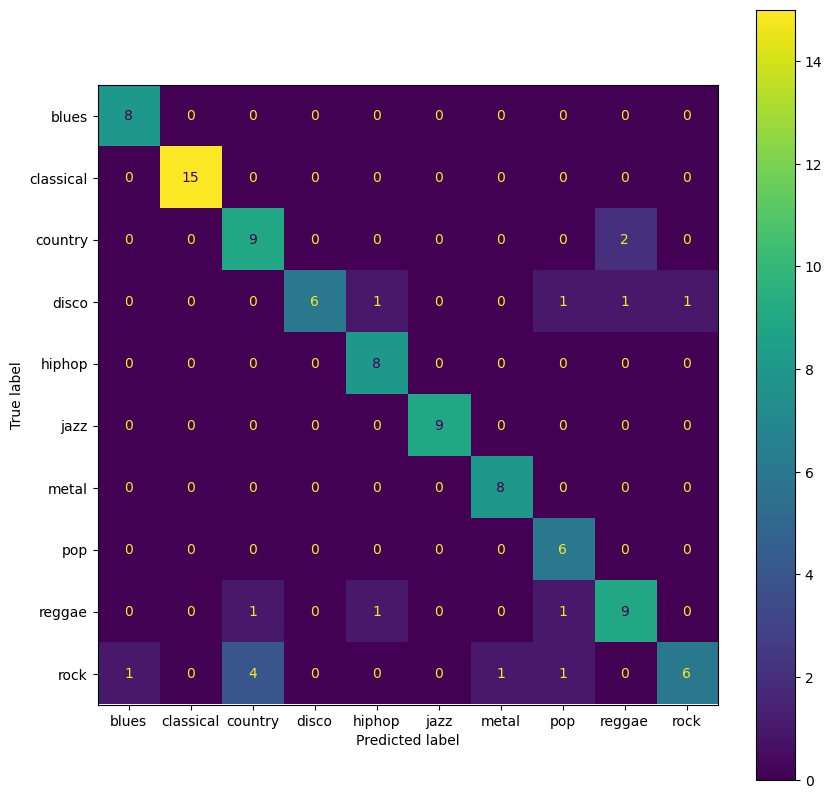

In [ ]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
if not os.path.exists("images"):
  os.mkdir("images")
fig.savefig(os.join("images","Test_confusion_matrix.jpg"))
plt.show()